# Hypertuning
### data
You can pick the gestures dataset, which is pretty fast en easy to reach high accuracy on.
You could also pick the flowers if you want to test images, or the ants/bees, or any other datasets from `mads_datasets` or even another set you like from [torchvision](https://pytorch.org/vision/0.8/datasets.html) or [torchtext](https://pytorch.org/text/stable/datasets.html#imdb).

Keep in mind that your hardware will limit what you can do with the images; if you have a GPU or use a free GPU from google colab, it's much faster to run tests.

## Create a model
We have worked with a few types of layers:
- linear
- conv2d
- RNNs (GRU, LSTM)
- dropout, batchnorm

and we have also seen architectures like resnet (skiplayers), squeeze-excite and googlenet (inception).
It's up to you to create a configurable model now that can be hypertuned.

## Goal
How do variables interact?
This means:
- pick a variable for the x-axis
- pick another variable for the y-axis
now you can use a metric as a third variable for color, and create heatmaps to explore how the two variables interact.

You will typically see that variables interact. For example, dropout will exclude random hidden units from a layer. This means that if you have more units, your dropout can be higher. Some variables you can consider, ranging from high to low importance:
- the architecture of the model is the most important. Number of layers, type of layers, skiplayers, etc.
- the number of hidden units
- learning rate in combination with an optimizer
- dropout
- batchnorm

The notebook 02_hypertune is an illustration of the interaction between number of layers and hidden units.
You will pick two other variables and explore their interaction.

IMPORTANT:
Dont use hyperband when trying to create a heatmap! Or, at least, dont put models that have run just a few epochs together with models that have run many epochs. This will NOT give you a clear overview of the interaction between the variables.

You CAN use hyperband if you want to speed up scans of big hyperparameter spaces, but always keep in mind that you DONT use this for plotting heatmaps.

- Visualise your finding
- reflect on what you see, using the theory. Please dont use chatGPT to reflect: you will get text that makes you look like an idiot. Instead, try to make mistakes, it wont be subtracted from your grade; making mistakes gives me an oportunity to correct you, which might actually help you during your exam.


## Implementing
Set up your own repository.
In hypertune.py, I have set up an example for hypertuning.
Implement your own hypertuner for another model / dataset from scratch.

- make sure your environment is reproducable
    - dont blindly reuse the environment from the lessons; use a minimal environment.
    - Check the [dependencies for mltrainer](https://github.com/raoulg/mltrainer/blob/main/pyproject.toml) to see whats already installed if you use mltrainer
    - have a look at the pyproject.toml file from the course;
        - `hpbandster` is for hyperband
        - `configspace` is a dependency for `hpbandster`.
        - `bayesian-optimization` is for, well, bayesian optimization
        - `hyperopt` is another hyperoptimalisation library which we have used in `2_convolutions/03_mlflow.ipynb`. It doesnt has as much algorithms as ray, which is why we use ray. Just know that `hyperopt` can be an alternative to `ray.tune` that's slightly easier to setup but less powerful.
- make a function to pull your data, you can use `mads_datasets` for this.
- make a *configurable model* where you can change the different options from the config
- build a hypertuner.py script
    - DO NOT use hyperband!
- make a README that explains your experiments
- Lint and format your code !! with black and ruff untill all your errors are gone !!

## Report
You will write a report of 1 page. Not 2, not 3. 1 page. Somehow this turns out to be very difficult for students :)
1 A4 page means you will have to be very clear with your report. Remove all clutter. Use clear visualisations. Make sure it's clear in a few seconds what the results are of every experiment.

You will get a:
- 0, which means: you will have to improve things, otherwise it will cost you points at your exam
- 1, meaning: your work is fine. There are some things to improve, but you are on the right track.
- 2, meaning: your work is excellent. You have done everything right, even exceeded expectations,and you have shown that you understand the material. If you do the same on the exam you will be good.

# Common gotchas

- you can't blindly copy paths. Always use `Path` and check if locations exist with `.exists()`
- If you want to add your own `src` folder for import, you need to figure out if your `src` folder is located at the ".." or "../.." location, relative to your notebook for a `sys.path.insert(0, "..")` command (that is, if you need to explicitly add it because the notebook cant find your src folder)
- same goes for datalocations. `"../../data/raw"` might have changed into `"../data/raw"` depending in your setup. `mads_datasets` uses `Path.home() / ".cache/mads_datasets"` as a default location, so you can use that from every folder on your computer.
- While developing functions, you can:
    1. Write the function in a .py file, and (re)load into a notebook if you change it. Note that ray tune can be problematic to run from inside a notebook.
    2. Make a hypertune.py file and excecute from the command line. You will never have problems with reloading functions, because that is done every time you start up.
- PRACTICE linting and formating (using a Makefile makes this easier). Black is simple, ruff too (it has a --fix argument to autofix issues), mypy takes more effort (because you need to typehint) but you will become a better programmer if you learn to think about the types of your input and output. Additionally mypy will catch possible errors that dont show up during a first run (but might show up later, with different input)

In [3]:
import os
from pathlib import Path
import urllib.request
import zipfile
from torchvision import datasets, transforms

# Define the directory to store the dataset
data_root = Path("./data")
data_root.mkdir(exist_ok=True)

# Path for the downloaded zip file and the extracted dataset folder
zip_file_path = data_root / "hymenoptera_data.zip"
dataset_folder = data_root / "hymenoptera_data"

# Download the dataset if it doesn't exist already
if not dataset_folder.exists():
    if not zip_file_path.exists():
        print("Downloading dataset...")
        url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
        urllib.request.urlretrieve(url, zip_file_path)
        print("Download complete!")
    else:
        print("Zip file already downloaded.")

    # Extract the dataset
    print("Extracting dataset...")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(data_root)
    print("Extraction complete!")
else:
    print("Dataset already exists.")

# Define a basic set of image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()         
])

# Load the dataset using ImageFolder
dataset = datasets.ImageFolder(root=str(dataset_folder), transform=transform)

# Print out some basic information about the dataset
print("Dataset loaded!")
print("Classes:", dataset.classes)
print("Number of images:", len(dataset))

Dataset already exists.
Dataset loaded!
Classes: ['train', 'val']
Number of images: 397


In [4]:
import torch
import torch.nn as nn

class ConfigurableCNN(nn.Module):
    def __init__(self, config):
        super(ConfigurableCNN, self).__init__()
        self.config = config
        
        layers = []
        in_channels = config.get("in_channels", 3)
        base_filters = config.get("base_filters", 16)
        num_conv_layers = config.get("num_conv_layers", 2)
        
        # Build a series of convolutional blocks
        for i in range(num_conv_layers):
            out_channels = base_filters * (2 ** i)
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            in_channels = out_channels
        
        self.conv = nn.Sequential(*layers)
        
        # Calculate the size of the flattened feature map
        input_size = config.get("input_size", 224)
        num_pools = num_conv_layers  
        conv_output_size = input_size // (2 ** num_pools)
        flattened_size = in_channels * conv_output_size * conv_output_size
        
        # Build the fully connected layers
        fc_units = config.get("fc_units", 128)
        dropout_rate = config.get("dropout", 0.5)
        self.fc = nn.Sequential(
            nn.Linear(flattened_size, fc_units),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(fc_units, config.get("num_classes", 2))
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1) 
        x = self.fc(x)
        return x

# Example usage of the configurable model
if __name__ == "__main__":
    # Define your model configuration
    config = {
        "in_channels": 3,         # RGB images
        "input_size": 224,        # Image dimensions (224x224)
        "base_filters": 16,       # Starting number of filters
        "num_conv_layers": 3,     # Number of convolutional blocks
        "fc_units": 128,          # Number of units in the fully connected layer
        "dropout": 0.5,           # Dropout probability
        "num_classes": 2          # Number of output classes (e.g., ants vs. bees)
    }
    
    # Create the model instance
    model = ConfigurableCNN(config)
    print(model)
    
    # Test the model with a dummy input to verify the output dimensions
    dummy_input = torch.randn(1, 3, 224, 224) 
    output = model(dummy_input)
    print("Output shape:", output.shape)


ConfigurableCNN(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=50176, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_featur


Training with dropout=0.3, num_conv_layers=2
Epoch 1/5, Loss: 12.7077, Val Acc: 0.4510
Epoch 2/5, Loss: 5.3588, Val Acc: 0.5294
Epoch 3/5, Loss: 3.0346, Val Acc: 0.5294
Epoch 4/5, Loss: 1.3051, Val Acc: 0.6471
Epoch 5/5, Loss: 0.5518, Val Acc: 0.6405

Training with dropout=0.3, num_conv_layers=3
Epoch 1/5, Loss: 6.6744, Val Acc: 0.4575
Epoch 2/5, Loss: 1.2557, Val Acc: 0.5229
Epoch 3/5, Loss: 0.6243, Val Acc: 0.6601
Epoch 4/5, Loss: 0.5748, Val Acc: 0.6078
Epoch 5/5, Loss: 0.4745, Val Acc: 0.6732

Training with dropout=0.3, num_conv_layers=4
Epoch 1/5, Loss: 4.9474, Val Acc: 0.5425
Epoch 2/5, Loss: 1.7455, Val Acc: 0.4575
Epoch 3/5, Loss: 1.0161, Val Acc: 0.5425
Epoch 4/5, Loss: 0.6489, Val Acc: 0.5098
Epoch 5/5, Loss: 0.5919, Val Acc: 0.5163

Training with dropout=0.5, num_conv_layers=2
Epoch 1/5, Loss: 10.5335, Val Acc: 0.6275
Epoch 2/5, Loss: 5.8597, Val Acc: 0.5817
Epoch 3/5, Loss: 1.4392, Val Acc: 0.4967
Epoch 4/5, Loss: 0.5790, Val Acc: 0.6013
Epoch 5/5, Loss: 0.5771, Val Acc: 0

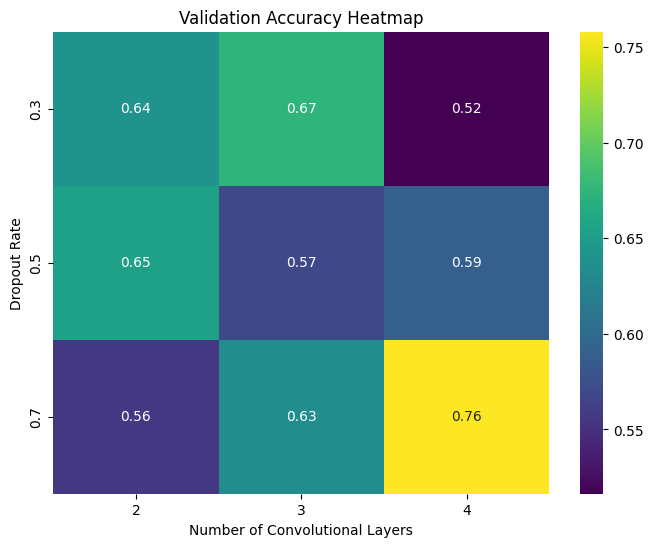

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the configurable CNN model (from the previous part)
class ConfigurableCNN(nn.Module):
    def __init__(self, config):
        super(ConfigurableCNN, self).__init__()
        self.config = config
        layers = []
        in_channels = config.get("in_channels", 3) 
        base_filters = config.get("base_filters", 16)
        num_conv_layers = config.get("num_conv_layers", 2)
        
        # Build convolutional blocks
        for i in range(num_conv_layers):
            out_channels = base_filters * (2 ** i)
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            in_channels = out_channels
        
        self.conv = nn.Sequential(*layers)
        
        # Calculate the size of the flattened features
        input_size = config.get("input_size", 224)
        num_pools = num_conv_layers 
        conv_output_size = input_size // (2 ** num_pools)
        flattened_size = in_channels * conv_output_size * conv_output_size
        
        # Build the fully connected layers
        fc_units = config.get("fc_units", 128)
        dropout_rate = config.get("dropout", 0.5)
        self.fc = nn.Sequential(
            nn.Linear(flattened_size, fc_units),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(fc_units, config.get("num_classes", 2))
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Define transforms for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Define paths to the dataset (assuming you downloaded and extracted the hymenoptera_data)
data_root = Path("./data/hymenoptera_data")
train_dir = data_root / "train"
val_dir = data_root / "val"

# Load the datasets
train_dataset = datasets.ImageFolder(root=str(train_dir), transform=transform)
val_dataset = datasets.ImageFolder(root=str(val_dir), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_loader, val_loader, device, epochs=5):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        
        # Evaluate on the validation set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_accuracy = correct / total
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Val Acc: {val_accuracy:.4f}")
    
    return val_accuracy

# Hyperparameter grid search: exploring different dropout rates and number of conv layers
dropout_rates = [0.3, 0.5, 0.7]
num_conv_layers_list = [2, 3, 4]

results = {}  # To store validation accuracy for each configuration

for dropout in dropout_rates:
    results[dropout] = {}
    for num_layers in num_conv_layers_list:
        print(f"\nTraining with dropout={dropout}, num_conv_layers={num_layers}")
        config = {
            "in_channels": 3,
            "input_size": 224,
            "base_filters": 16,
            "num_conv_layers": num_layers,
            "fc_units": 128,
            "dropout": dropout,
            "num_classes": len(train_dataset.classes)
        }
        model = ConfigurableCNN(config)
        val_acc = train_model(model, train_loader, val_loader, device, epochs=5)
        results[dropout][num_layers] = val_acc

# Print grid search results
print("\nGrid Search Results:")
for dropout in results:
    for num_layers in results[dropout]:
        print(f"Dropout: {dropout}, Layers: {num_layers}, Val Acc: {results[dropout][num_layers]:.4f}")

# Visualize the results as a heatmap
heatmap_data = np.array([[results[d][l] for l in num_conv_layers_list] for d in dropout_rates])
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, xticklabels=num_conv_layers_list, yticklabels=dropout_rates, cmap="viridis")
plt.xlabel("Number of Convolutional Layers")
plt.ylabel("Dropout Rate")
plt.title("Validation Accuracy Heatmap")
plt.show()
